In [155]:
# Imports
import os
import yaml
import scipy
import pickle
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.stats.proportion
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings("ignore")

In [156]:
# DNA information
dna_length = 10.439         # kbp
origin = 6.896              # kbp location of the origin of replication
NPS1 = 6.750                # kbp location of the first nucleosome position sequence
NPS2 = 7.04                 # kbp location of the second nucleosome position sequence
locs_from_center = [ dna_length/2 - origin]  # Locations from center in kbp.

# Location bins; origin should be in third bin
binwidth = (origin - dna_length/2) / 2.5

In [157]:
def plot_location_traces_selected (data, ax, fig, plot_id=False, lines=None):
    """Plot all traces from data dictionary, generated with get_location_traces(). You can show the track ids on the
    resulting figure with plot_id=True; you can add horizontal lines by setting lines to a list of floats."""
    fig = fig
    ax = ax
    if lines is None:
        lines = []
        
    import random
    
    aList = data['traces'].items()
    CHlist = random.sample(aList, round (0.3*len ( data['traces'].items())))
    for i, trace in CHlist:

        # plt.scatter(trace['t'], trace['x'], color=trace['color'], s=4) ,'#7d0404'
        #plt.plot(trace['t'], trace['x'], color=trace['color'])
        plt.plot(trace['t'], trace['x'], color='#7d0404')
        if trace['split']:
            # print(trace['split_t'], trace['split_x'])
            plt.plot(trace['split_t'], trace['split_x'], color='purple')
        if plot_id and trace['count'] > 0:
            plt.text((np.amax(trace['t']) + 1), np.amax(trace['x']),
                     str((trace['scan_id'], trace['trace_id'], trace['track_id'])), color=trace['color'])

    #plt.title('Location traces')
    ax.set_xlim(0, 100)
    ax.set_ylim((0, data['x_max']))
    #if data['t_unit'] == 'frame':
       # ax.set_xlabel('t (frame)')
    #elif data['t_unit'] == 's':
        #ax.set_xlabel('t (s)')
   # if data['x_unit'] == 'micron':
       # ax.set_ylabel('x (micron)')
   # elif data['x_unit'] == 'kbp':
       # ax.set_ylabel('x (kbp)')
    for line in lines:
        plt.plot([0, data['t_max']], [line, line], color='k', linestyle='dashed')
    plt.tight_layout()
    #plt.close()

    return fig

def plot_diffusion_hist(data, fig, ax,
                        fit_function=None, fit_params=None, show_wilson_confint=True,filename=None,color='#b20000', edgecolor='k'):
    """Plot diffusion coefficient histogram using the dictionary generated with get_diffusion_hist()."""
    
    fig= fig
    ax= ax
    
    #fig = plt.figure(figsize=(4, 4))
    plt.bar(data['bins'], data['values'], width=data['bin_width'], color=color, edgecolor=edgecolor)
    #plt.title("Diffusion histogram, N = " + str(len(data['diff_coeffs_log'])))
    #plt.title("Nfoci= " + str(len (data ['diff_coeffs_log'])))
    if data['x_unit'] == 'micron':
        plt.xlabel('log(D) (micron**2/s)')
    else:
        plt.xlabel(f'log(D) kbp\N{SUPERSCRIPT TWO}/s')
    if fit_function is not None:
        x = np.linspace(np.amin(data['bins']) - data['bin_width']/2, np.amax(data['bins']) + data['bin_width'], 100)
        plt.plot(x, data['bin_width'] * fit_function(x, *fit_params),lw= 2, c="k")
    if show_wilson_confint:
        plt.errorbar(data['bins'], data['values'], data['wilson_confint'],
                     capsize=4, linewidth=0, elinewidth=1, ecolor='k')
    plt.ylabel('Fraction')
    plt.xlim((-8, 1))
    #plt.ylim((0, 0.7))
    plt.xticks([-8, -6, -4, -2, 0])
    #plt.yticks([0, 0.2, 0.4])
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4])
    plt.annotate("$N_{foci}$ = "  + str(len (data ['diff_coeffs_log'])), xy=(0.99, 0.98), 
            xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')

    return fig

def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)


def count_non_empty(df_in, chromatin_color='b'):
    """Count not empty scans."""
    exp_names = []
    for scan_id, df_scan in df_in.groupby('scan_id'):
        if (df_scan['color_str'] == chromatin_color).all():
            # only chromatin, do not count
            pass
        else:
            exp_names.append(df_scan['file_name'].iloc[0])
    return len(exp_names)

In [158]:
def gaussian(x, mu, sigma):
    return np.exp(-(x - mu) ** 2 / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))


def bigaussian(x, mu1, sig1, a1, mu2, sig2):
    return a1 * np.exp(-(x - mu1) ** 2 / (2 * sig1 ** 2)) / (sig1 * np.sqrt(2 * np.pi)) + \
           (1.0-a1) * np.exp(-(x - mu2) ** 2 / (2 * sig2 ** 2)) / (sig2 * np.sqrt(2 * np.pi))

fit_func = {
    'gaussian' : gaussian,
    'bigaussian' : bigaussian
}

In [159]:
# Figure a) i.
with open(os.path.join('figure_data', 'Figure 3', 'ai', 'data1.yaml'), "r") as file:
    data1 = yaml.safe_load(file)

# Figure a) ii.
with open(os.path.join('figure_data', 'Figure 3', 'aii', 'data2.yaml'), "r") as file:
    data2 = yaml.safe_load(file)

In [160]:
# Figure b) i.
with open(os.path.join('figure_data', 'Figure 3', 'bi', 'data_s8.yaml'), "r") as file:
    data_s8 = yaml.safe_load(file)

fit_func_s8 = bigaussian

with open(os.path.join('figure_data', 'Figure 3', 'bi', 'fit_params_s8.pkl'), "rb") as file:
    fit_params_s8 = pickle.load(file)

# Figure b) ii.
with open(os.path.join('figure_data', 'Figure 3', 'bii', 'data_s7.yaml'), "r") as file:
    data_s7 = yaml.safe_load(file)

fit_func_s7 = bigaussian

with open(os.path.join('figure_data', 'Figure 3', 'bii', 'fit_params_s7.pkl'), "rb") as file:
    fit_params_s7 = pickle.load(file)

# Figure b) iii.
with open(os.path.join('figure_data', 'Figure 3', 'biii', 'data_s26.yaml'), "r") as file:
    data_s26 = yaml.safe_load(file)

fit_func_s26 = bigaussian

with open(os.path.join('figure_data', 'Figure 3', 'biii', 'fit_params_s26.pkl'), "rb") as file:
    fit_params_s26 = pickle.load(file)

# Figure b) iv.
with open(os.path.join('figure_data', 'Figure 3', 'biv', 'data_s25.yaml'), "r") as file:
    data_s25 = yaml.safe_load(file)

fit_func_s25 = bigaussian

with open(os.path.join('figure_data', 'Figure 3', 'biv', 'fit_params_s25.pkl'), "rb") as file:
    fit_params_s25 = pickle.load(file)

In [161]:
# Figure c) Fit params
with open(os.path.join('figure_data', 'Figure 3', 'c', 'fit_params_s8_origin.pkl'), "rb") as file:
    fit_params_s8_origin = pickle.load(file)

with open(os.path.join('figure_data', 'Figure 3', 'c', 'fit_params_s7_origin.pkl'), "rb") as file:
    fit_params_s7_origin = pickle.load(file)

with open(os.path.join('figure_data', 'Figure 3', 'c', 'fit_params_s26_origin.pkl'), "rb") as file:
    fit_params_s26_origin = pickle.load(file)

with open(os.path.join('figure_data', 'Figure 3', 'c', 'fit_params_s25_origin.pkl'), "rb") as file:
    fit_params_s25_origin = pickle.load(file)

# Off origin
with open(os.path.join('figure_data', 'Figure 3', 'c', 'fit_params_s8_off_origin.pkl'), "rb") as file:
    fit_params_s8_off_origin = pickle.load(file)

with open(os.path.join('figure_data', 'Figure 3', 'c', 'fit_params_s7_off_origin.pkl'), "rb") as file:
    fit_params_s7_off_origin = pickle.load(file)

with open(os.path.join('figure_data', 'Figure 3', 'c', 'fit_params_s26_off_origin.pkl'), "rb") as file:
    fit_params_s26_off_origin = pickle.load(file)

with open(os.path.join('figure_data', 'Figure 3', 'c', 'fit_params_s25_off_origin.pkl'), "rb") as file:
    fit_params_s25_off_origin = pickle.load(file)

# Figure c) Plot data
with open(os.path.join('figure_data', 'Figure 3', 'c', 'data_s8_origin.yaml'), "rb") as file:
    data_s8_origin = yaml.safe_load(file)

with open(os.path.join('figure_data', 'Figure 3', 'c', 'data_s7_origin.yaml'), "rb") as file:
    data_s7_origin = yaml.safe_load(file)

with open(os.path.join('figure_data', 'Figure 3', 'c', 'data_s26_origin.yaml'), "rb") as file:
    data_s26_origin = yaml.safe_load(file)

with open(os.path.join('figure_data', 'Figure 3', 'c', 'data_s25_origin.yaml'), "rb") as file:
    data_s25_origin = yaml.safe_load(file)

# Off origin
with open(os.path.join('figure_data', 'Figure 3', 'c', 'data_s8_off_origin.yaml'), "rb") as file:
    data_s8_off_origin = yaml.safe_load(file)

with open(os.path.join('figure_data', 'Figure 3', 'c', 'data_s7_off_origin.yaml'), "rb") as file:
    data_s7_off_origin = yaml.safe_load(file)

with open(os.path.join('figure_data', 'Figure 3', 'c', 'data_s26_off_origin.yaml'), "rb") as file:
    data_s26_off_origin = yaml.safe_load(file)

with open(os.path.join('figure_data', 'Figure 3', 'c', 'data_s25_off_origin.yaml'), "rb") as file:
    data_s25_off_origin = yaml.safe_load(file)

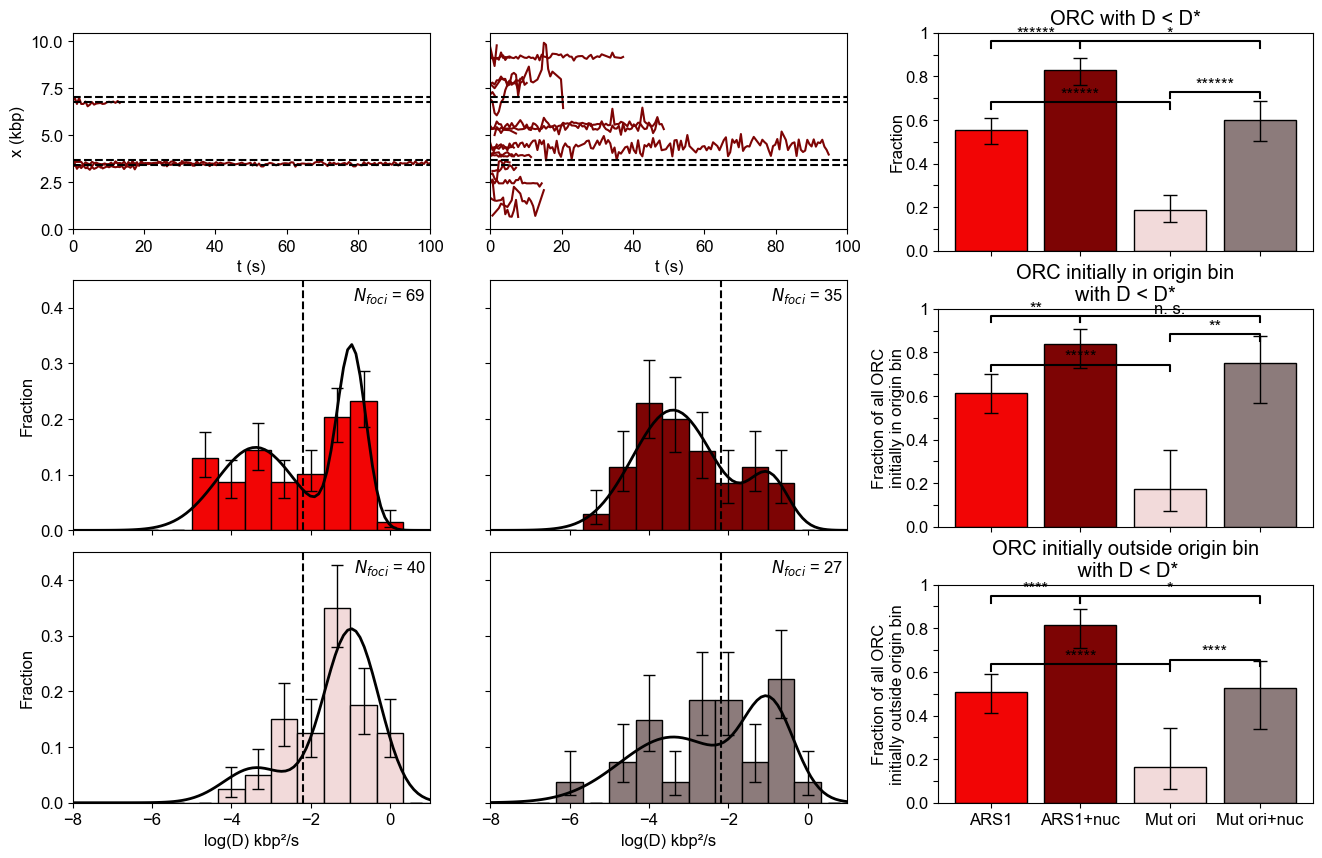

In [162]:
# Config plot parameters
font = {'family':'arial', 'size'   : 12}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42

# Create figure
fig = plt.figure(constrained_layout=True, figsize=(round(scipy.constants.golden_ratio *10), 10))
gs1 = fig.add_gridspec(nrows=215, ncols=208)

# Figure a) i.
ax1 = fig.add_subplot(gs1[0:55, 0:60])     # top left    
plot_location_traces_selected(data1, ax1, fig, lines=[NPS1, dna_length-NPS1, NPS2, dna_length-NPS2])
plt.xlabel('t (s)')
plt.ylabel('x (kbp)')


# Figure a) ii.
ax2 = fig.add_subplot(gs1[0:55, 70:130])   # top middle   
plot_location_traces_selected(data2, ax2, fig, lines=[NPS1, dna_length-NPS1, NPS2, dna_length-NPS2])
ax2.tick_params(labelleft=False)
plt.xlabel('t (s)')


# Diffusion
mu1 = -3.3966722508276828
mu2 = -0.9731424083906166
threshold = (mu1 + mu2)/2 # average  of mu1 and mu2 

# Figure b) i.
ax4 = fig.add_subplot(gs1[69:139, 0:60]) # bottom midlle left (size: 8x10  - 40x50)
plot_diffusion_hist(data_s8, fig, ax4, fit_func_s8, fit_params_s8, color='#f20505', show_wilson_confint=True)
ax4.axvline(x=threshold, color='k', linestyle='--')
ax4.tick_params(labelbottom=False)
plt.xlabel('') 
plt.ylim(0, 0.45)   
    
# Figure b) ii.
ax5 = fig.add_subplot(gs1[69:139, 70:130])   # middle middle     (size: 12x7  - 60x35)
plot_diffusion_hist(data_s7, fig, ax5, fit_func_s7, fit_params_s7, color='#7d0404', show_wilson_confint=True)
ax5.axvline(x=threshold, color='k', linestyle='--')
ax5.tick_params(labelleft=False, labelbottom=False)
plt.xlabel('') 
plt.ylabel('') 
plt.ylim(0, 0.45)

# Figure b) iii.
ax10 = fig.add_subplot(gs1[145:215, 0:60])    # bottom left 
plot_diffusion_hist(data_s26, fig, ax10, fit_func_s26, fit_params_s26, color='#f2dada', show_wilson_confint=True)
ax10.axvline(x=threshold, color='k', linestyle='--')
plt.ylim(0, 0.45)

# Figure b) iv.
ax11 = fig.add_subplot(gs1[145:215, 70:130])   # bottom middle  (size: 8x10  - 40x50)
plot_diffusion_hist(data_s25, fig, ax11, fit_func_s25, fit_params_s25, color='#8c7b7b', show_wilson_confint=True)
ax11.axvline(x=threshold, color='k', linestyle='--')
ax11.tick_params(labelleft=False, labelbottom=True)
plt.ylabel('') 
plt.ylim(0, 0.45)

# Figure c) top
ax6 = fig.add_subplot(gs1[0:61, 145:208])    # top right    (size: 12x13 - 60x65)

# Errors
read_freq_s8 = fit_params_s8[2]
N_8 = len (data_s8 ['diff_coeffs_log'])

err8s = list(statsmodels.stats.proportion.proportion_confint(read_freq_s8*N_8, N_8,
                                                                       alpha=0.3173, method='wilson'))
err8s[0] = read_freq_s8 - err8s[0]
err8s[1] = err8s[1] - read_freq_s8


read_freq_s7 = fit_params_s7[2]
N_7 = len (data_s7 ['diff_coeffs_log'])

err7s = list(statsmodels.stats.proportion.proportion_confint(read_freq_s7*N_7, N_7,
                                                                       alpha=0.3173, method='wilson'))
err7s[0] = read_freq_s7 - err7s[0]
err7s[1] = err7s[1] - read_freq_s7


read_freq_s26 = fit_params_s26[2]
N_26 = len (data_s26 ['diff_coeffs_log'])

err26s = list(statsmodels.stats.proportion.proportion_confint(read_freq_s26*N_26, N_26,
                                                                       alpha=0.3173, method='wilson'))
err26s[0] = read_freq_s26 - err26s[0]
err26s[1] = err26s[1] - read_freq_s26

read_freq_s25 = fit_params_s25[2]
N_25 = len (data_s25 ['diff_coeffs_log'])

err25s = list(statsmodels.stats.proportion.proportion_confint(read_freq_s25*N_25, N_25,
                                                                       alpha=0.3173, method='wilson'))
err25s[0] = read_freq_s25 - err25s[0]
err25s[1] = err25s[1] - read_freq_s25


# Organize errors
errs4 = []
errs4.append(err8s)
errs4.append(err7s)
errs4.append(err26s)
errs4.append(err25s)
errs4 = np.array(errs4).swapaxes(0, 1)


height = [read_freq_s8,  read_freq_s7,read_freq_s26,  read_freq_s25]
bars = ('ARS1', 'ARS1+\nnuc', 'Mut ori',  'Mut ori+\nnuc')
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height,color=['#f20505',  '#7d0404', '#f2dada', '#8c7b7b'], edgecolor='k')

# Create names on the x-axis
plt.xticks(y_pos, bars)

plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ('0.0', ' ','0.2',' ','0.4',' ','0.6', ' ','0.8',
                                                                   ' ','1'))

ax6.set_title('ORC with D < D*')
plt.ylim(0, 1)
plt.ylabel('Fraction', labelpad=0)

# Add standard error of the proportion
plt.errorbar( y_pos, height, errs4, fmt=' ', color='k', capsize=5, elinewidth=1, markeredgewidth=1)

# Perform binomial test
p_val_1=stats.binom_test(read_freq_s8* N_8,
                         N_8, read_freq_s26, alternative='two-sided')
p_val_2=stats.binom_test(read_freq_s7* N_7,
                         N_7, read_freq_s25, alternative='two-sided')
p_val_3=stats.binom_test(read_freq_s8* N_8,
                         N_8, read_freq_s7, alternative='two-sided') 
p_val_4=stats.binom_test(read_freq_s26* N_26,
                         N_26, read_freq_s25, alternative='two-sided') 

# Annotate
barplot_annotate_brackets(0, 2, p_val_1, y_pos, height, dh=.1, barh=.03, maxasterix= 6)
barplot_annotate_brackets(1, 3, p_val_2, y_pos, height, dh=.1, barh=.03, maxasterix= 6)
barplot_annotate_brackets(0, 1, p_val_3, y_pos, height, dh=.1, barh=.03, maxasterix= 6)
barplot_annotate_brackets(2, 3, p_val_4, y_pos, height, dh=.1, barh=.03, maxasterix= 6)

ax6.tick_params(labelleft=True, labelbottom=False)
 
 
# Figure c) middle
ax9 = fig.add_subplot(gs1[77:138, 145:208])     # middle right     (size: 12x7  - 60x35)

# Errors
read_freq_s8_or = fit_params_s8_origin[2]
N_8_or = len (data_s8_origin ['diff_coeffs_log'])

err8s_or = list(statsmodels.stats.proportion.proportion_confint(read_freq_s8_or*N_8_or, N_8_or,
                                                                       alpha=0.3173, method='wilson'))
err8s_or[0] = read_freq_s8_or - err8s_or[0]
err8s_or[1] = err8s_or[1] - read_freq_s8_or


read_freq_s7_or = fit_params_s7_origin[2]
N_7_or = len (data_s7_origin ['diff_coeffs_log'])

err7s_or = list(statsmodels.stats.proportion.proportion_confint(read_freq_s7_or*N_7_or, N_7_or,
                                                                       alpha=0.3173, method='wilson'))
err7s_or[0] = read_freq_s7_or - err7s_or[0]
err7s_or[1] = err7s_or[1] - read_freq_s7_or


read_freq_s26_or = fit_params_s26_origin[2]
N_26_or = len (data_s26_origin ['diff_coeffs_log'])

err26s_or = list(statsmodels.stats.proportion.proportion_confint(read_freq_s26_or*N_26_or, N_26_or,
                                                                       alpha=0.3173, method='wilson'))
err26s_or[0] = read_freq_s26_or - err26s_or[0]
err26s_or[1] = err26s_or[1] - read_freq_s26_or


read_freq_s25_or = fit_params_s25_origin[2]
N_25_or = len (data_s25_origin ['diff_coeffs_log'])

err25s_or = list(statsmodels.stats.proportion.proportion_confint(read_freq_s25_or*N_25_or, N_25_or,
                                                                       alpha=0.3173, method='wilson'))
err25s_or[0] = read_freq_s25_or - err25s_or[0]
err25s_or[1] = err25s_or[1] - read_freq_s25_or


# Organize errors
errs5 = []
errs5.append(err8s_or)
errs5.append(err7s_or)
errs5.append(err26s_or)
errs5.append(err25s_or)
errs5 = np.array(errs5).swapaxes(0, 1)

height = [read_freq_s8_or,  read_freq_s7_or, read_freq_s26_or, read_freq_s25_or]
bars = ('ARS1',  'ARS1+nuc', 'Mut ori','Mut ori+nuc')
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height,color=['#f20505',  '#7d0404', '#f2dada', '#8c7b7b'], edgecolor='k')

# Create names on the x-axis
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ('0.0', ' ','0.2',' ','0.4',' ','0.6', ' ','0.8',
                                                                   ' ','1'))

ax9.set_title('ORC initially in origin bin\nwith D < D*')
plt.ylim(0, 1)
plt.ylabel('Fraction of all ORC\ninitially in origin bin', labelpad=0)  #"%.2f" % fval,
plt.errorbar( y_pos, height, errs5, fmt=' ', color='k', capsize=5, elinewidth=1, markeredgewidth=1)

# Perform binomial test
p_val_1_b=stats.binom_test(read_freq_s8_or* N_8_or,
                         N_8_or, read_freq_s26_or, alternative='two-sided')
p_val_2_b=stats.binom_test(read_freq_s7_or* N_7_or,
                         N_7_or, read_freq_s25_or, alternative='two-sided')
 
p_val_3_b=stats.binom_test(read_freq_s8_or* N_8_or,
                         N_8_or, read_freq_s7_or, alternative='two-sided')
p_val_4_b=stats.binom_test(read_freq_s26_or* N_26_or,
                         N_26_or, read_freq_s25_or, alternative='two-sided')
 
# Annotate
barplot_annotate_brackets(0, 2, p_val_1_b, y_pos, height, dh=.1, barh=.03, maxasterix= 6)
barplot_annotate_brackets(1, 3, p_val_2_b, y_pos, height, dh=.1, barh=.03, maxasterix= 6)
barplot_annotate_brackets(0, 1, p_val_3_b, y_pos, height, dh=.1, barh=.03, maxasterix= 6)
barplot_annotate_brackets(2, 3, p_val_4_b, y_pos, height, dh=.1, barh=.03, maxasterix= 6)

ax9.tick_params(labelleft=True, labelbottom=False)

# Figure c) bottom
ax7 = fig.add_subplot(gs1[154:215, 145:208]) 

read_freq_s8_off_origin = fit_params_s8_off_origin[2]
N_8_off_origin = len (data_s8_off_origin ['diff_coeffs_log'])

err8s_off_origin = list(statsmodels.stats.proportion.proportion_confint(read_freq_s8_off_origin*N_8_off_origin, N_8_off_origin,
                                                                       alpha=0.3173, method='wilson'))
err8s_off_origin[0] = read_freq_s8_off_origin - err8s_off_origin[0]
err8s_off_origin[1] = err8s_off_origin[1] - read_freq_s8_off_origin


read_freq_s7_off_origin = fit_params_s7_off_origin[2]
N_7_off_origin = len (data_s7_off_origin ['diff_coeffs_log'])

err7s_off_origin = list(statsmodels.stats.proportion.proportion_confint(read_freq_s7_off_origin*N_7_off_origin, N_7_off_origin,
                                                                       alpha=0.3173, method='wilson'))
err7s_off_origin[0] = read_freq_s7_off_origin - err7s_off_origin[0]
err7s_off_origin[1] = err7s_off_origin[1] - read_freq_s7_off_origin


read_freq_s26_off_origin = fit_params_s26_off_origin[2]
N_26_off_origin = len (data_s26_off_origin ['diff_coeffs_log'])

err26s_off_origin = list(statsmodels.stats.proportion.proportion_confint(read_freq_s26_off_origin*N_26_off_origin, N_26_off_origin,
                                                                       alpha=0.3173, method='wilson'))
err26s_off_origin[0] = read_freq_s26_off_origin - err26s_off_origin[0]
err26s_off_origin[1] = err26s_off_origin[1] - read_freq_s26_off_origin


read_freq_s25_off_origin = fit_params_s25_off_origin[2]
N_25_off_origin = len (data_s25_off_origin ['diff_coeffs_log'])

err25s_off_origin = list(statsmodels.stats.proportion.proportion_confint(read_freq_s25_off_origin*N_25_off_origin, N_25_off_origin,
                                                                       alpha=0.3173, method='wilson'))
err25s_off_origin[0] = read_freq_s25_off_origin - err25s_off_origin[0]
err25s_off_origin[1] = err25s_off_origin[1] - read_freq_s25_off_origin

# Organize errors
errs6 = []
errs6.append(err8s_off_origin)
errs6.append(err7s_off_origin)
errs6.append(err26s_off_origin)
errs6.append(err25s_off_origin)
errs6 = np.array(errs6).swapaxes(0, 1)

height = [read_freq_s8_off_origin, read_freq_s7_off_origin, read_freq_s26_off_origin,  read_freq_s25_off_origin]
bars = ('ARS1', 'ARS1+nuc','Mut ori',   'Mut ori+nuc')
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height,color=['#f20505',  '#7d0404', '#f2dada', '#8c7b7b'], edgecolor='k')

# Create names on the x-axis
plt.xticks(y_pos, bars)#, rotation= 45, ha='right', rotation_mode='anchor')
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ('0.0', ' ','0.2',' ','0.4',' ','0.6', ' ','0.8',
                                                                    ' ','1'))
ax7.set_title('ORC initially outside origin bin\n with D < D*')
plt.ylim(0, 1)
plt.ylabel('Fraction of all ORC\ninitially outside origin bin', labelpad=0)

# Add standard error of the proportion
plt.errorbar( y_pos, height, errs5, fmt=' ', color='k', capsize=5, elinewidth=1, markeredgewidth=1)

# Perform binomial test
p_val_1_c=stats.binom_test(read_freq_s8_off_origin* N_8_off_origin,
                         N_8_off_origin, read_freq_s26_off_origin, alternative='two-sided')
p_val_2_c=stats.binom_test(read_freq_s7_off_origin* N_7_off_origin,
                         N_7_off_origin, read_freq_s25_off_origin, alternative='two-sided')
p_val_3_c=stats.binom_test(read_freq_s8_off_origin* N_8_off_origin,
                         N_8_off_origin, read_freq_s7_off_origin, alternative='two-sided') 
p_val_4_c=stats.binom_test(read_freq_s26_off_origin* N_26_off_origin,
                         N_26_off_origin, read_freq_s25_off_origin, alternative='two-sided') 

# Annotate
barplot_annotate_brackets(0, 2, p_val_1_c, y_pos, height, dh=.1, barh=.03, maxasterix= 6)
barplot_annotate_brackets(1, 3, p_val_2_c, y_pos, height, dh=.1, barh=.03, maxasterix= 6)
barplot_annotate_brackets(0, 1, p_val_3_c, y_pos, height, dh=.1, barh=.03, maxasterix= 6)
barplot_annotate_brackets(2, 3, p_val_4_c, y_pos, height, dh=.1, barh=.03, maxasterix= 6)

plt.show()